In [113]:
# 0. Load tools
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from collections import Counter, defaultdict
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [114]:
# 1. Load data and test for dataset artifacts
dataset = load_dataset("snli")

def clean_text(text: str):
    text = text.lower()
    text = text.translate(str.maketrans("","", string.punctuation))
    return text.split()

def clean_snli(example):
    example["premise"] = clean_text(example["premise"])
    example["hypothesis"] = clean_text(example["hypothesis"])
    example["combined"] = example["premise"] + example["hypothesis"]
    return example

dataset = dataset.map(clean_snli)


In [119]:
# Flatten tokens and count words
all_tokens = [token for example in dataset['train']['combined'] for token in example]

word_counts = Counter(all_tokens)
word_counts_df = pd.DataFrame(word_counts.items(), columns=["word", "count"])
word_counts_df = word_counts_df.sort_values(by="count", ascending=False).reset_index(drop=True)
print(word_counts_df.head())

  word    count
0    a  1441033
1  the   535480
2   in   407657
3   is   373879
4  man   264899


In [120]:
# Count by label
label_word_counts = {
    "entailment": defaultdict(int),
    "contradiction": defaultdict(int),
    "neutral": defaultdict(int),
}

# Count word occurrences for each label
for example in dataset["train"]:
    label = example["label"]
    label_name = ["entailment", "neutral", "contradiction"][label]
    for word in example["combined"]:
        label_word_counts[label_name][word] += 1

entailment_counts = pd.DataFrame(list(label_word_counts["entailment"].items()), columns=["word", "entailment_count"])
contradiction_counts = pd.DataFrame(list(label_word_counts["contradiction"].items()), columns=["word", "contradiction_count"])
neutral_counts = pd.DataFrame(list(label_word_counts["neutral"].items()), columns=["word", "neutral_count"])

word_counts_df = word_counts_df.merge(entailment_counts, on="word", how="left").fillna(0)
word_counts_df = word_counts_df.merge(contradiction_counts, on="word", how="left").fillna(0)
word_counts_df = word_counts_df.merge(neutral_counts, on="word", how="left").fillna(0)

# Ensure counts are integers
word_counts_df[["entailment_count", "contradiction_count", "neutral_count"]] = word_counts_df[
    ["entailment_count", "contradiction_count", "neutral_count"]
].astype(int)

In [121]:
# get p-hat and z-scores
word_counts_df = word_counts_df[word_counts_df['count'] >= 3].copy()
alpha = 0.01/word_counts_df.shape[0]
z_star = norm.ppf(1 - alpha)
print(z_star)
print(word_counts_df.shape[0])
word_counts_df['alpha'] = 0.01
word_counts_df['p_hat_entailment'] = word_counts_df['entailment_count']/word_counts_df['count']
word_counts_df['p_hat_contradiction'] = word_counts_df['contradiction_count']/word_counts_df['count']
word_counts_df['p_hat_neutral'] = word_counts_df['neutral_count']/word_counts_df['count']
word_counts_df['z_stat_entailment'] = (word_counts_df['p_hat_entailment']-(1/3)) / np.sqrt(((1/3)*(1-(1/3)))/word_counts_df['count'])
word_counts_df['z_stat_contradiction'] = (word_counts_df['p_hat_contradiction']-(1/3)) / np.sqrt(((1/3)*(1-(1/3)))/word_counts_df['count'])
word_counts_df['z_stat_neutral'] = (word_counts_df['p_hat_neutral']-(1/3)) / np.sqrt(((1/3)*(1-(1/3)))/word_counts_df['count'])
word_counts_df['critical_z'] = z_star
word_counts_df.head()


4.917728622559877
22843


,word,count,entailment_count,contradiction_count,neutral_count,alpha,p_hat_entailment,p_hat_contradiction,p_hat_neutral,z_stat_entailment,z_stat_contradiction,z_stat_neutral,critical_z
0,a,1441033,482788,476520,481725,0.01,0.335029,0.330679,0.334291,4.318285,-6.758107,2.439822,4.917729
1,the,535480,149005,192938,193537,0.01,0.278264,0.360309,0.361427,-85.484004,41.873779,43.610225,4.917729
2,in,407657,131902,142144,133611,0.01,0.323561,0.348685,0.327753,-13.235544,20.793016,-7.557472,4.917729
3,is,373879,122284,126665,124930,0.01,0.327068,0.338786,0.334146,-8.126236,7.072728,1.053508,4.917729
4,man,264899,87633,89561,87705,0.01,0.330817,0.338095,0.331088,-2.747735,5.198715,-2.450980,4.917729


In [ ]:
# Print words that violate competency problem assumption

long_df = pd.melt(
    word_counts_df,
    id_vars=["word", "count", "critical_z"],
    value_vars=["z_stat_entailment", "z_stat_contradiction", "z_stat_neutral"],
    var_name="label",
    value_name="z_stat"
)

# Map the z_stat column to meaningful labels
long_df["label"] = long_df["label"].map({
    "z_stat_entailment": "entailment",
    "z_stat_contradiction": "contradiction",
    "z_stat_neutral": "neutral"
})

# Filter for rejected words
rejected_words_df = long_df[long_df["z_stat"] > long_df["critical_z"]].copy()

# Drop unnecessary columns and reset the index
rejected_words_df = rejected_words_df[["word", "z_stat", "label"]].reset_index(drop=True)

# Display the resulting DataFrame
rejected_words_df = rejected_words_df.sort_values(by="z_stat", ascending=False).reset_index(drop=True)
rejected_words_df.head(50)

,word,z_stat,label
0,for,93.611083,neutral
1,to,82.831527,neutral
2,sleeping,80.755878,contradiction
3,outside,77.393703,entailment
4,there,77.187633,entailment
5,nobody,68.427476,contradiction
6,outdoors,65.017694,entailment
7,no,52.650922,contradiction
8,cat,50.740618,contradiction
9,friends,48.490141,neutral


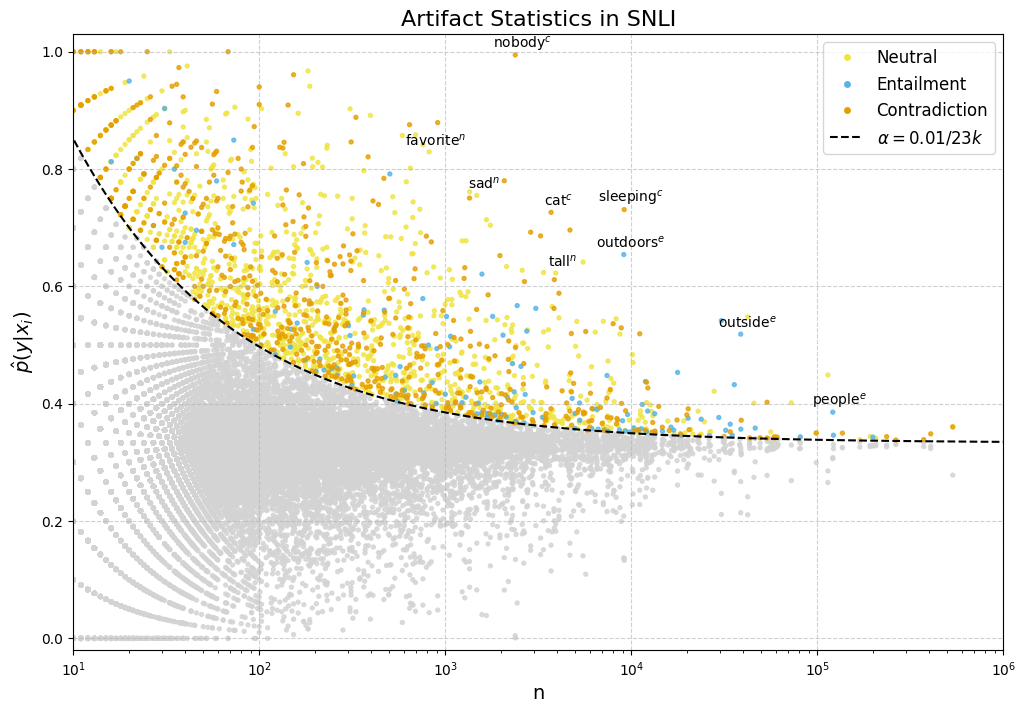

In [156]:
annotations = {
    "contradiction": ["sleeping", "cat", "nobody"],
    "neutral": ["tall", "sad", "favorite"],
    "entailment": ["outside", "people", "outdoors"]
}

def add_annotations(ax, df, words, superscript, x_col, y_col):
    for word in words:
        point = df[df["word"] == word]
        if not point.empty:
            x = point[x_col].values[0]
            y = point[y_col].values[0]
            ax.annotate(
                f"{word}{superscript}", 
                (x, y), 
                fontsize=10, 
                xytext=(5, 5),
                textcoords="offset points", 
                ha="center"
            )
            
def conditional_colors(p_hat_values, counts, default_color, threshold_function):
    colors = []
    for p_hat, count in zip(p_hat_values, counts):
        threshold = threshold_function(count)
        if p_hat < threshold:
            colors.append("#D3D3D3")
        else:
            colors.append(default_color)
    return colors

rejection_threshold = lambda count: (z_star / (3 * np.sqrt(count))) + (1 / 3)
n_values = np.logspace(np.log10(word_counts_df['count'].min()), np.log10(word_counts_df['count'].max()), 500)
p_hat_threshold = (z_star / (3 * np.sqrt(n_values))) + (1 / 3)

neutral_colors = conditional_colors(word_counts_df['p_hat_neutral'], word_counts_df['count'], "#F0E442", rejection_threshold)
entailment_colors = conditional_colors(word_counts_df['p_hat_entailment'], word_counts_df['count'], "#56B4E9", rejection_threshold)
contradiction_colors = conditional_colors(word_counts_df['p_hat_contradiction'], word_counts_df['count'], "#E69F00", rejection_threshold)

plt.figure(figsize=(12, 8))

plt.scatter(
    word_counts_df['count'], 
    word_counts_df['p_hat_neutral'], 
    label='Neutral', 
    alpha=.8, 
    c=neutral_colors, 
    s=8
)

plt.scatter(
    word_counts_df['count'], 
    word_counts_df['p_hat_entailment'], 
    label='Entailment', 
    alpha=.8, 
    c=entailment_colors, 
    s=8
)

plt.scatter(
    word_counts_df['count'], 
    word_counts_df['p_hat_contradiction'], 
    label='Contradiction', 
    alpha=.8, 
    c=contradiction_colors, 
    s=8
)

plt.plot(
    n_values, 
    p_hat_threshold, 
    label=r"$\alpha = 0.01/23k$", 
    color="black", 
    linestyle="--", 
    linewidth=1.5
)

# Add annotations to the plot
ax = plt.gca()  # Get the current axes
add_annotations(ax, word_counts_df, annotations["contradiction"], r"$^c$", "count", "p_hat_contradiction")
add_annotations(ax, word_counts_df, annotations["neutral"], r"$^n$", "count", "p_hat_neutral")
add_annotations(ax, word_counts_df, annotations["entailment"], r"$^e$", "count", "p_hat_entailment")


# Set log scale for x-axis
plt.xscale("log")

# Set y-axis limits to leave some space at the bottom
plt.ylim(-0.02, 1.03)  # Extend slightly below 0
plt.xlim(10, 10e5)  # Leave space on the left

# Add labels, legend, and title
plt.xlabel("n", fontsize=14)
plt.ylabel(r"$\hat{p}(y | x_i)$", fontsize=14)
plt.title("Artifact Statistics in SNLI", fontsize=16)
plt.legend(title="", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Neutral', markersize=6, markerfacecolor="#F0E442"),
        plt.Line2D([0], [0], marker='o', color='w', label='Entailment', markersize=6, markerfacecolor="#56B4E9"),
        plt.Line2D([0], [0], marker='o', color='w', label='Contradiction', markersize=6, markerfacecolor="#E69F00"),
        plt.Line2D([0], [0], color="black", label=r"$\alpha = 0.01/23k$", linestyle="--", linewidth=1.5)
    ],
    fontsize=12,
    title="",
)

# Show the plot
plt.show()


In [ ]:
# This is where we begin training the model
dataset = load_dataset("snli")

# Initialize model + tokenizer
model_name = "google/electra-small-discriminator"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
if hasattr(model, 'electra'):
        for param in model.electra.parameters():
            if not param.is_contiguous():
                param.data = param.data.contiguous()
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def preprocess(example):
    return tokenizer(example['premise'], example['hypothesis'], truncation=True, padding='max_length', max_length=tokenizer.model_max_length)

dataset = dataset.filter(lambda ex: ex['label'] != -1)
encoded_dataset = dataset.map(preprocess, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")  # Ensure labels are named correctly
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=500,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
)
trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
